<h1><center>Stock Market Trading Bot</center></h1>

# Importing libraries

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data Source

[Data Source](https://www.kaggle.com/ghazanfarali/ksedataset?select=UBL.csv)

# Loading data

In [2]:
UBL=pd.read_csv('Data/UBL.csv',index_col='Date',parse_dates=True)
HBL=pd.read_csv('Data/HBL.csv',index_col='Date',parse_dates=True)
NBP=pd.read_csv('Data/NBP.csv',index_col='Date',parse_dates=True)
MEBL=pd.read_csv('Data/MEBL.csv',index_col='Date',parse_dates=True)

UBL.head()

,Symbol,Open,High,Low,Close,Volume
Date,,,,,,
2005-05-26,UBL,61.25,68.00,59.10,59.85,1990000
2005-05-27,UBL,60.00,61.40,58.60,59.40,573700
2005-05-30,UBL,59.00,59.75,56.45,58.40,1026700
2005-05-31,UBL,57.50,58.50,57.10,58.35,684500
2005-06-01,UBL,58.50,61.20,58.15,60.75,1103500


# Plotting Data

Text(0.5, 1.0, 'Trend of Share Price of different KSE-30 Companies')

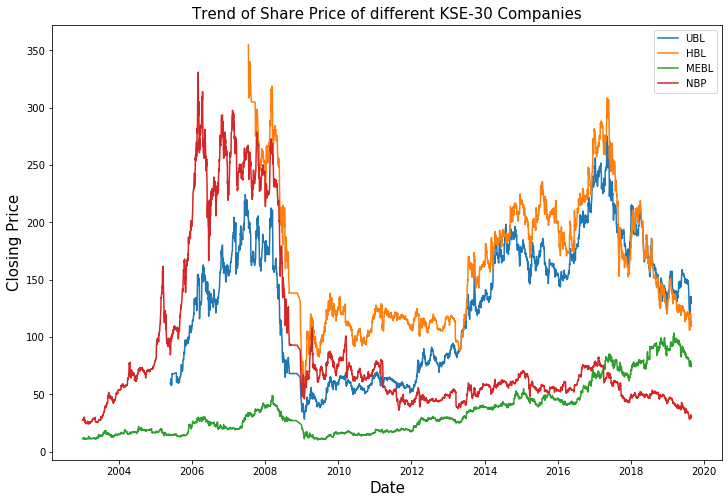

In [3]:
plt.figure(figsize=(12,8))
sns.lineplot(data=UBL.Close,label='UBL')
sns.lineplot(data=HBL.Close,label='HBL')
sns.lineplot(data=MEBL.Close,label='MEBL')
sns.lineplot(data=NBP.Close,label='NBP')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Closing Price',fontsize=15)
plt.title('Trend of Share Price of different KSE-30 Companies',fontsize=15)

# Dropping redundant feature

In [4]:
UBL.drop('Symbol',axis=1,inplace=True)
MEBL.drop('Symbol',axis=1,inplace=True)
NBP.drop('Symbol',axis=1,inplace=True)
HBL.drop('Symbol',axis=1,inplace=True)

# Changing column names in order to facilitate merge

In [5]:
UBL.columns=['UBL_Open','UBL_High','UBL_Low','UBL_Close','UBL_Volume']
MEBL.columns=['MEBL_Open','MEBL_High','MEBL_Low','MEBL_Close','MEBL_Volume']
HBL.columns=['HBL_Open','HBL_High','HBL_Low','HBL_Close','HBL_Volume']


In [6]:
UBL.info(),MEBL.info(),NBP.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2005-05-26 to 2019-08-30
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   UBL_Open    3449 non-null   float64
 1   UBL_High    3449 non-null   float64
 2   UBL_Low     3449 non-null   float64
 3   UBL_Close   3449 non-null   float64
 4   UBL_Volume  3449 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 161.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3986 entries, 2003-01-01 to 2019-08-30
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MEBL_Open    3986 non-null   float64
 1   MEBL_High    3986 non-null   float64
 2   MEBL_Low     3986 non-null   float64
 3   MEBL_Close   3986 non-null   float64
 4   MEBL_Volume  3986 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 186.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4073 entries, 

(None, None, None)

# Merging Data Frame

In [7]:
data=pd.concat([UBL,MEBL,HBL],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4055 entries, 2003-01-01 to 2019-08-30
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UBL_Open     3449 non-null   float64
 1   UBL_High     3449 non-null   float64
 2   UBL_Low      3449 non-null   float64
 3   UBL_Close    3449 non-null   float64
 4   UBL_Volume   3449 non-null   float64
 5   MEBL_Open    3986 non-null   float64
 6   MEBL_High    3986 non-null   float64
 7   MEBL_Low     3986 non-null   float64
 8   MEBL_Close   3986 non-null   float64
 9   MEBL_Volume  3986 non-null   float64
 10  HBL_Open     2948 non-null   float64
 11  HBL_High     2948 non-null   float64
 12  HBL_Low      2948 non-null   float64
 13  HBL_Close    2948 non-null   float64
 14  HBL_Volume   2948 non-null   float64
dtypes: float64(15)
memory usage: 506.9 KB


# Reversing Data Frame

In [8]:
data1=data.iloc[::-1]

In [ ]:
! pip install plotly

In [22]:
! pip install dash==1.17.0

     |████████████████████████████████| 75 kB 44 kB/s eta 0:00:011
     |████████████████████████████████| 1.0 MB 39 kB/s eta 0:00:011
     |████████████████████████████████| 3.5 MB 77 kB/s eta 0:00:011
     |████████████████████████████████| 188 kB 341 kB/s eta 0:00:01    |████████▊                       | 51 kB 355 kB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 98 kB/s eta 0:00:012
     |████████████████████████████████| 357 kB 92 kB/s eta 0:00:011
  Created wheel for dash: filename=dash-1.17.0-py3-none-any.whl size=83726 sha256=e1e5cde157b8df13094345b6413f10568bb56ca8e604c39af04440811facaddd
  Stored in directory: /home/rufus/.cache/pip/wheels/28/60/30/2f9f3884e6c75ea2588026586e6b1a6e95922d7369ce2c8dba
  Created wheel for flask-compress: filename=Flask_Compress-1.7.0-py3-none-any.whl size=6833 sha256=d4d61b8afdb759550839ec4db875fa1aedb0de4082661b3d74ec81fd6a5e234e
  Stored in directory: /home/rufus/.cache/pip/wheels/be/96/89/a2cc475456cabcc3f099ceb5d7b09608436e69a86

In [9]:
x=data1.reset_index()

In [10]:
x.head()

,Date,UBL_Open,UBL_High,UBL_Low,UBL_Close,UBL_Volume,MEBL_Open,MEBL_High,MEBL_Low,MEBL_Close,MEBL_Volume,HBL_Open,HBL_High,HBL_Low,HBL_Close,HBL_Volume
0,2019-08-30,132.0,134.25,129.00,129.44,722500.0,75.29,77.0,74.01,75.12,319500.0,112.24,114.00,108.21,109.57,1290300.0
1,2019-08-29,133.1,136.00,132.00,132.72,466900.0,77.40,78.0,75.00,75.29,184000.0,114.00,115.00,110.00,110.74,690400.0
2,2019-08-28,132.9,137.25,132.25,135.23,1200800.0,74.24,77.5,73.55,76.52,825500.0,113.89,115.40,113.00,113.25,663400.0
3,2019-08-27,132.0,133.00,127.02,132.53,932200.0,75.32,75.5,73.01,74.02,691000.0,115.00,115.89,110.75,113.53,1512700.0
4,2019-08-26,132.0,132.50,130.13,130.53,1115900.0,77.00,77.0,74.50,75.32,139500.0,117.00,117.95,114.15,115.93,184900.0


In [14]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime



fig = go.Figure(data=[go.Candlestick(x=x['Date'],
                open=x['UBL_Open'],
                high=x['UBL_High'],
                low=x['UBL_Low'],
                close=x['UBL_Close'])])

fig.show()


In [15]:
data1.head()

,UBL_Open,UBL_High,UBL_Low,UBL_Close,UBL_Volume,MEBL_Open,MEBL_High,MEBL_Low,MEBL_Close,MEBL_Volume,HBL_Open,HBL_High,HBL_Low,HBL_Close,HBL_Volume
Date,,,,,,,,,,,,,,,
2019-08-30,132.0,134.25,129.00,129.44,722500.0,75.29,77.0,74.01,75.12,319500.0,112.24,114.00,108.21,109.57,1290300.0
2019-08-29,133.1,136.00,132.00,132.72,466900.0,77.40,78.0,75.00,75.29,184000.0,114.00,115.00,110.00,110.74,690400.0
2019-08-28,132.9,137.25,132.25,135.23,1200800.0,74.24,77.5,73.55,76.52,825500.0,113.89,115.40,113.00,113.25,663400.0
2019-08-27,132.0,133.00,127.02,132.53,932200.0,75.32,75.5,73.01,74.02,691000.0,115.00,115.89,110.75,113.53,1512700.0
2019-08-26,132.0,132.50,130.13,130.53,1115900.0,77.00,77.0,74.50,75.32,139500.0,117.00,117.95,114.15,115.93,184900.0


# Dropping Missing Values

In [16]:
data1.dropna(inplace=True)

/home/rufus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
data1.isnull().sum().sum()

0

# Basic correlation analysis

In [18]:
data2=data1.drop(['UBL_Volume','MEBL_Volume','HBL_Volume'],axis=1)

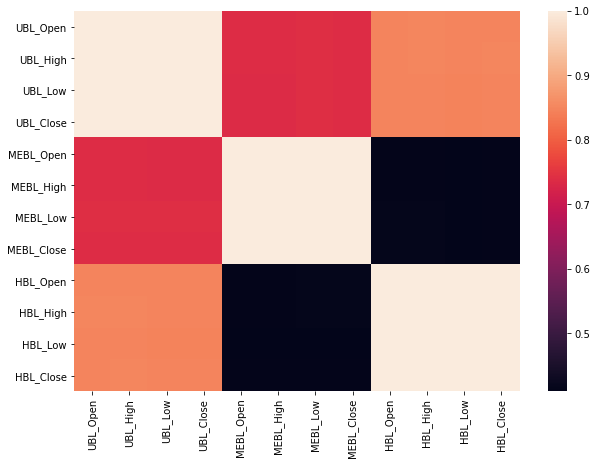

In [19]:
plt.figure(figsize=(10,7))
sns.heatmap(data=data2.corr())

# Box Plot

Text(0.5, 1.0, 'Trend of Share Price of different KSE-30 Companies')

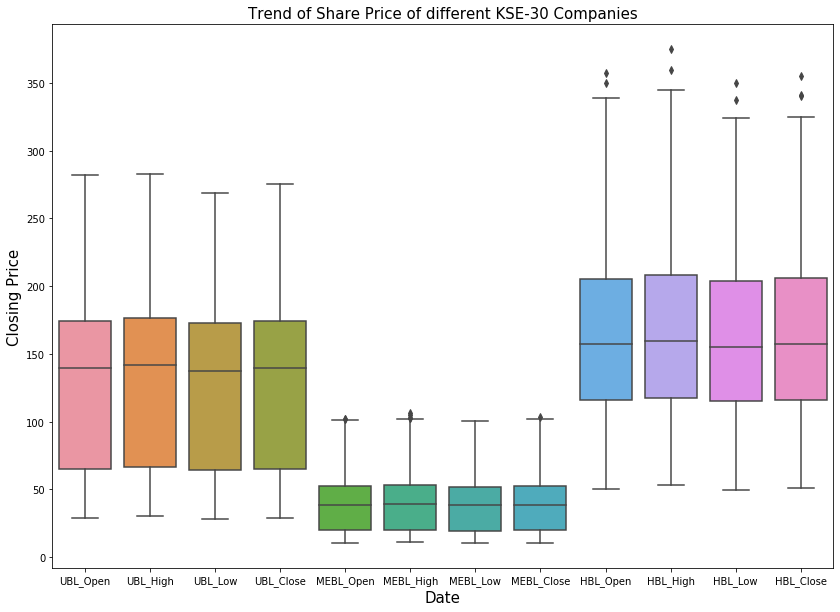

In [20]:
plt.figure(figsize=(14,10))
sns.boxplot(data=data2)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Closing Price',fontsize=15)
plt.title('Trend of Share Price of different KSE-30 Companies',fontsize=15)

# Backend of Trading Framework

In [21]:
def shares_trading(X,total_shares,nS1,nS2,nS3,share_prices,model1_pred,model2_pred,model3_pred,low_thres,high_thres):
    if (model1_pred>model2_pred and model1_pred>model3_pred) and (nS1/total_shares)<high_thres:
        if (model2_pred>model3_pred) and (nS3/(total_shares))>low_thres:
            Amount_Gained=((nS3*share_price[2])*.20)
            Brocker_fee=((nS3*share_price[2])*.20)*.15*.01
            nS3-=(nS3*.2)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=int(Amount_Gained/share_price[0])
            nS1=nS1+Shares_bought
            X-=Amount_Gained
        if (model3_pred>model2_pred) and (nS2/(total_shares))>low_thres:
            Amount_Gained=((nS2*share_price[1])*.20)
            Brocker_fee=((nS2*share_price[1])*.20)*.15*.01
            nS2-=(nS2*.2)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=Amount_Gained/share_price[0]
            nS1+=Shares_bought
            X-=Amount_Gained
        if model3_pred<0 and (nS3/(total_shares))>low_thres:
            Amount_Gained=((nS3*share_price[2])*.20)
            Brocker_fee=((nS3*share_price[2])*.20)*.15*.01
            nS3-=(nS3*.2)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=int(Amount_Gained/share_price[0])
            nS1=nS1+Shares_bought
            X-=Amount_Gained
        if model2_pred<0 and (nS2/(total_shares))>low_thres:
            Amount_Gained=((nS2*share_price[1])*.20)
            Brocker_fee=((nS2*share_price[1])*.20)*.15*.01
            nS2-=(nS2*.2)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=Amount_Gained/share_price[0]
            nS1+=Shares_bought
            X-=Amount_Gained
        return X,nS1,nS2,nS3
    
    if (model2_pred>model1_pred and model2_pred>model3_pred) and (nS2/total_shares)<high_thres:
        if (model1_pred>model3_pred) and (nS3/(total_shares))>low_thres:
            Amount_Gained=((nS3*share_price[2])*.20)
            Brocker_fee=((nS3*share_price[2])*.20)*.15*.01
            nS3-=(nS3*.2)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=Amount_Gained/share_price[0]
            nS2+=Shares_bought
        if (model3_pred>model2_pred) and (nS2/(total_shares))>low_thres:
            Amount_Gained=((nS1*share_price[0])*.20)
            Brocker_fee=((nS1*share_price[0])*.20)*.15*.01
            nS1-=(nS1*.2)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=Amount_Gained/share_price[0]
            nS2+=Shares_bought
            X-=Amount_Gained
        if model3_pred<0 and (nS3/(total_shares))>low_thres:
            Amount_Gained=((nS3*share_price[2])*.20)
            Brocker_fee=((nS3*share_price[2])*.20)*.15*.01
            nS3-=(nS3*.2)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=int(Amount_Gained/share_price[0])
            nS2=nS2+Shares_bought
            X-=Amount_Gained
        if model1_pred<0 and (nS1/(total_shares))>low_thres:
            Amount_Gained=((nS1*share_price[1])*.20)
            Brocker_fee=((nS1*share_price[1])*.20)*.15*.01
            nS1-=(nS1*.2)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=Amount_Gained/share_price[0]
            nS2+=Shares_bought
            X-=Amount_Gained
        return X,nS1,nS2,nS3
    
    if (model3_pred>model1_pred and model3_pred>model2_pred) and (nS3/total_shares)<high_thres:
        if (model2_pred>model1_pred) and (nS1/(total_shares))>low_thres:
            Amount_Gained=((nS1*share_price[0])*.2)
            Brocker_fee=((nS1*share_price[0])*.2)*.15*.01
            nS1-=(nS1*.2)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=Amount_Gained/share_price[0]
            nS3+=Shares_bought
            X-=Amount_Gained
        if (model1_pred>model2_pred) and (nS2/(total_shares))>low_thres:
            Amount_Gained=((nS2*share_price[1])*.2)
            Brocker_fee=((nS2*share_price[1])*.2)*.15*.01
            nS2-=(nS2*.2)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=Amount_Gained/share_price[0]
            nS3+=Shares_bought
            X-=Amount_Gained
        if model1_pred<0 and (nS3/(total_shares))>low_thres:
            Amount_Gained=((nS3*share_price[2])*.2)
            Brocker_fee=((nS3*share_price[2])*.2)*.15*.01
            nS1-=(nS1*.2)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=int(Amount_Gained/share_price[0])
            nS3=nS3+Shares_bought
            X-=Amount_Gained
        if model2_pred<0 and (nS2/(total_shares))>low_thres:
            Amount_Gained=((nS2*share_price[1])*.2)
            Brocker_fee=((nS2*share_price[1])*.2)*.15*.01
            nS2-=(nS2*.2)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=Amount_Gained/share_price[0]
            nS3+=Shares_bought
            X-=Amount_Gained
        return X,nS1,nS2,nS3
        


# Front End of Trading Framework

In [ ]:
%matplotlib notebook
plt.rcParams['animation.html']='jshtml'

In [ ]:
data1.index=data1.index.astype('str')
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
i=0
x,y=[],[]
x1,y1=[],[]
x2,y2=[],[]
while True:
    x.append(data1.index[i])
    y.append(data1.UBL_Close[i])
    x1.append(data1.index[i])
    y1.append(data1.HBL_Close[i])
    x2.append(data1.index[i])
    y2.append(data1.MEBL_Close[i])
    ax.plot(x,y,color='blue')
    ax.plot(x1,y1,color='green')
    ax.plot(x2,y2,color='purple')
    plt.xticks(rotation=90)
    ax.legend(['UBL','HBL','MEBL'],loc='upper left')
    plt.show()
    fig.canvas.draw()
    time.sleep(1)
    i+=1

# Initialize basic amount X and number of shares

In [ ]:
X=1000
nS1=330
nS2=330
nS3=330


# Unit Testing

In [ ]:
total_shares=nS1+nS2+nS3
model1_pred=np.random.rand()
model2_pred=np.random.rand()
model3_pred=np.random.rand()
low_thres=.2
high_thres=.5
share_price=[22.5,21.5,12.5]
X,nS1,nS2,nS3=shares_trading(X,total_shares,nS1,nS2,nS3,share_price,
                           model1_pred,model2_pred,model3_pred,
                           low_thres,high_thres)
model1_pred,model2_pred,model3_pred

In [ ]:
model1_pred,model2_pred,model3_pred

# Investment Portfolio

In [ ]:
X,nS1/total_shares,nS2/total_shares,nS3/total_shares

In [ ]:
X,nS1/total_shares,nS2/total_shares,nS3/total_shares

# Installing Gradient Boosted Tree model

In [ ]:
!pip install XGBoost

In [ ]:
data=df

In [ ]:
from sklearn import model_selection
import xgboost as xgb
from sklearn import metrics

In [ ]:
df['date'] = df.index
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
    
X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','Open','High','Low','Volume']]

In [ ]:
X.head()

In [ ]:
X.Open=X.Open.astype('float')
X.High=X.High.astype('float')
X.Low=X.Low.astype('float')
X.Volume=X.Volume.astype('float')

In [ ]:
y=data[['Close']]

In [ ]:
y=y.astype('float')
X

In [ ]:
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.2)

# Training model

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train)

In [ ]:
yhat=reg.predict(X_test)

In [ ]:
#sns.lineplot(data=yhat)
sns.lineplot(data=y_test)

In [ ]:
sns.lineplot(data=yhat)


In [ ]:
metrics.mean_squared_error(y_test,yhat)

In [ ]:
yhat=reg.predict(X_train)

In [ ]:
sns.lineplot(data=yhat)

In [ ]:
sns.lineplot(data=y_test)